# Time series data prediction 

In [18]:
#dowloading the apple stock market dataset
# !wget https://raw.githubusercontent.com/abhinav-TB/Time-Series-Forecasting-Using-LSTM/master/AAPL.csv

In [19]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
df = pd.read_csv('AAPL.csv')
import torchsummary

In [20]:
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [21]:
df1 = df.reset_index()['close']

In [22]:
df1

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

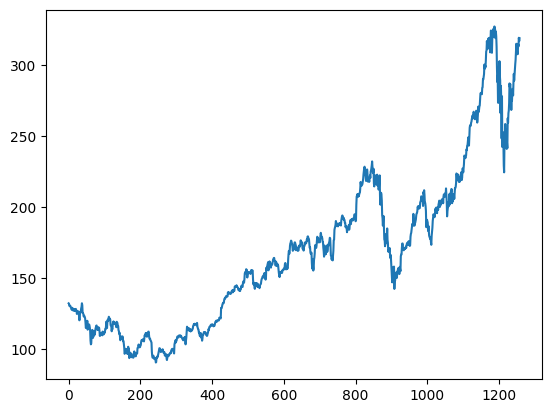

In [23]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [24]:
# normalising the dataset to values bewtween 0 and 1

import numpy as np
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(0,1))
df1 = scalar.fit_transform(np.array(df1).reshape(-1,1))

In [25]:
df1

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       ...,
       [0.96635143],
       [0.9563033 ],
       [0.96491598]])

In [26]:
##splitting dataset into train and test split for time series data
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]


In [27]:
class StockDataset(Dataset):
    def __init__(self,data,seq_len = 100):
        self.data = data
        self.data = torch.from_numpy(data).float().view(-1)
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.data)-self.seq_len-1

    def __getitem__(self, index) :
        return  self.data[index : index+self.seq_len] , self.data[index+self.seq_len]


train_dataset = StockDataset(train_data) 
test_dataset = StockDataset(test_data) 





In [28]:
aa,bb = train_dataset.__getitem__(2)
print(aa,'\n',bb)

tensor([0.1686, 0.1697, 0.1673, 0.1679, 0.1647, 0.1617, 0.1582, 0.1565, 0.1627,
        0.1615, 0.1555, 0.1544, 0.1573, 0.1560, 0.1585, 0.1531, 0.1574, 0.1549,
        0.1595, 0.1569, 0.1537, 0.1443, 0.1481, 0.1531, 0.1524, 0.1506, 0.1492,
        0.1361, 0.1255, 0.1391, 0.1491, 0.1489, 0.1540, 0.1612, 0.1658, 0.1762,
        0.1706, 0.1473, 0.1470, 0.1442, 0.1369, 0.1395, 0.1378, 0.1352, 0.1307,
        0.1186, 0.1026, 0.1058, 0.1047, 0.1063, 0.1240, 0.0977, 0.1051, 0.1047,
        0.1082, 0.1132, 0.1104, 0.1042, 0.0942, 0.0651, 0.0540, 0.0566, 0.0817,
        0.0953, 0.0969, 0.0947, 0.0734, 0.0929, 0.0846, 0.0799, 0.0928, 0.0836,
        0.0939, 0.1008, 0.1054, 0.1095, 0.1101, 0.0996, 0.0976, 0.1050, 0.0974,
        0.1012, 0.1041, 0.1029, 0.0933, 0.0790, 0.0843, 0.0812, 0.0846, 0.0863,
        0.0885, 0.0863, 0.0809, 0.0920, 0.0898, 0.0906, 0.0839, 0.0909, 0.0874,
        0.0903]) 
 tensor(0.0989)


In [29]:
batch_size = 64
train_dataloader = DataLoader(train_dataset,batch_size,drop_last=True) 
test_dataloader = DataLoader(test_dataset,batch_size , drop_last=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [78]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim , hidden_size , num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim , hidden_size = hidden_size , num_layers= num_layers )
        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x,hn,cn):
        out , (hn,cn) = self.lstm(x , (hn,cn))
        final_out = self.fc(out[-1])
        return final_out,hn,cn

    def predict(self,x):
        hn,cn  = self.init()
        final_out = self.fc(out[-1])
        return final_out

    def init(self):
        h0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        c0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        return h0 , c0


input_dim = 1 
hidden_size = 50
num_layers = 3
loss_fn = nn.MSELoss()
model = Lstm_model(input_dim , hidden_size , num_layers).to(device)



In [36]:
'''
自己写的，去掉模型的一部分，来打印模型
'''
import torchkeras
from torchkeras import summary
class Lstm_model(nn.Module):
    def __init__(self, input_dim , hidden_size , num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim , hidden_size = hidden_size , num_layers= num_layers )
        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x):
        out,_  = self.lstm(x)
        final_out = self.fc(out[-1])
        return final_out

loss_fn = nn.MSELoss()
net= Lstm_model(input_dim=1,hidden_size=50,num_layers=1)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
model = torchkeras.KerasModel(net,loss_fn=nn.MSELoss(),optimizer=optimizer)

for features,labels in train_dataloader:
    break
# summary(model,input_data=features.reshape([64,100,1])) 也可以！！！
# 需要.reshape([64,100,1]),否则报错:
# RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 100
# features.shape == torch.Size([64, 100])

summary(model,input_shape=(100,1)) # 这种也可以，少了64，因为每次输入模型的是时间序列100的一个样本，每个时间戳的维度是1，所以是（100,1）  
# 总之，如果用 input_data,则需要reshape(batch_size,seq_len,input_dim)
# 如果用 input_shape,则不需要考虑batch_size,直接用shape(seq_len,input_dim)

'''
数据输入是100个时间步，每个时间步是1维，即（64,100,1）
数据输出是100个时间步，每个时间步是50维，也就是hidden_size的大小。每个lstm单元都会输出一个状态h，所以是（64，100,50）
取最后一个单元的输出，也就是最后一个50，也就是每个样本100个时间步输入进去，得到的100个输出的最后一个。

全连接层的输入也就是最后一个单元的输出，即输入大小是50，输出大小是1

[-1,1]中的-1代表自动计算batch_size
--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
==========================================================================
LSTM-1                                 [-1, 100, 50]               10,600
Linear-2                                     [-1, 1]                   51
'''

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
LSTM-1                                 [-1, 100, 50]               10,600
Linear-2                                     [-1, 1]                   51
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000381
Forward/backward pass size (MB): 0.038155
Params size (MB): 0.040630
Estimated Total Size (MB): 0.079166
--------------------------------------------------------------------------


'\n数据输入是100个时间步，每个时间步是1维，即（64,100,1）\n数据输出是100个时间步，每个时间步是50维，也就是hidden_size的大小。每个lstm单元都会输出一个状态h，所以是（64，100,50）\n取最后一个单元的输出，也就是最后一个50，也就是每个样本100个时间步输入进去，得到的100个输出的最后一个。\n\n全连接层的输入也就是最后一个单元的输出，即输入大小是50，输出大小是1\n\n[-1,1]中的-1代表自动计算batch_size\n--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nLSTM-1                                 [-1, 100, 50]               10,600\nLinear-2                                     [-1, 1]                   51\n'

In [79]:
for batch , item in enumerate(test_dataloader):
    x , y = item
    x = x.to(device) # 不可以写作x.to(device)，这样x的设备并没有变化
    y = y.to(device)
print(y.shape)

torch.Size([64])


In [80]:
x.reshape(100,64,1)

tensor([[[0.5010],
         [0.4999],
         [0.4870],
         ...,
         [0.7432],
         [0.7344],
         [0.7494]],

        [[0.7469],
         [0.7339],
         [0.7140],
         ...,
         [0.5772],
         [0.5660],
         [0.5771]],

        [[0.5900],
         [0.6158],
         [0.6144],
         ...,
         [0.8986],
         [0.9258],
         [0.9288]],

        ...,

        [[0.7455],
         [0.7521],
         [0.7618],
         ...,
         [0.7423],
         [0.8233],
         [0.7814]],

        [[0.6666],
         [0.7922],
         [0.6412],
         ...,
         [0.9495],
         [0.9642],
         [0.9551]],

        [[0.9599],
         [0.9664],
         [0.9625],
         ...,
         [0.7878],
         [0.7516],
         [0.7843]]], device='cuda:0')

In [81]:
def train(dataloader):
    hn , cn = model.init()
    model.train()
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device) # 不可以写作x.to(device)，这样x的设备并没有变化
        y = y.to(device)
        out , hn , cn = model(x.reshape(100,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
        hn = hn.detach() # 将隐藏状态hn从计算图中分离，防止梯度累积,且节省计算资源
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch == len(dataloader)-1:
            loss = loss.item() # 将损失值从张量转换为数值
            print(f"train loss: {loss:>7f} ")


In [82]:
def test(dataloader):
    hn , cn = model.init()
    model.eval()
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(100,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
       
        if batch == len(dataloader)-1:
            loss = loss.item()
            print(f"test loss: {loss:>7f} ")


In [83]:
epochs = 200
for epoch in range(epochs):
    print(f"epoch {epoch} ")
    train(train_dataloader)
    test(test_dataloader)

epoch 0 
train loss: 0.212404 
test loss: 0.759794 
epoch 1 
train loss: 0.212404 
test loss: 0.759794 
epoch 2 
train loss: 0.212404 
test loss: 0.759794 
epoch 3 
train loss: 0.212404 
test loss: 0.759794 
epoch 4 
train loss: 0.212404 
test loss: 0.759794 
epoch 5 
train loss: 0.212404 
test loss: 0.759794 
epoch 6 
train loss: 0.212404 
test loss: 0.759794 
epoch 7 
train loss: 0.212404 
test loss: 0.759794 
epoch 8 
train loss: 0.212404 
test loss: 0.759794 
epoch 9 
train loss: 0.212404 
test loss: 0.759794 
epoch 10 
train loss: 0.212404 
test loss: 0.759794 
epoch 11 
train loss: 0.212404 
test loss: 0.759794 
epoch 12 
train loss: 0.212404 
test loss: 0.759794 
epoch 13 
train loss: 0.212404 
test loss: 0.759794 
epoch 14 
train loss: 0.212404 
test loss: 0.759794 
epoch 15 
train loss: 0.212404 
test loss: 0.759794 
epoch 16 
train loss: 0.212404 
test loss: 0.759794 
epoch 17 
train loss: 0.212404 
test loss: 0.759794 
epoch 18 
train loss: 0.212404 
test loss: 0.759794 
epo

In [84]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(data_loader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn , cn = model.init()
        for batch , item in enumerate(data_loader):
            x , y = item
            x , y = x.to(device) , y.to(device)
            x = x.view(100,64,1)
            pred = model(x,hn,cn)[0]
            pred = scalar.inverse_transform(pred.detach().cpu().numpy()).reshape(-1)
            y = scalar.inverse_transform(y.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
        print(pred_arr[21],y_arr[21])
        return math.sqrt(mean_squared_error(y_arr,pred_arr))
    

In [85]:
# calculating final loss metrics
print(f"train mse loss {calculate_metrics(train_dataloader)}")
print(f"test mse loss {calculate_metrics(test_dataloader)}")

79.95961 114.174995
train mse loss 65.3615993674803
80.01186 170.42
test mse loss 156.67480378358545
